# Skillbox — Мастер-класс: Разведочный анализ данных + Подготовка отчётов — Kiva.org
***

# 4. Домашнее задание
***

## 4.1. Самостоятельная работа
***

- А в каких странах преобладают мужчины? Группа людей? (п. 2.2.2.)
- Изучите несколько займов с очень большими суммами. Что можно сказать о назначении этих заявок? В каких странах они оформлены? Каков гендерный состав заявителей? (п. 2.4.2.)
- Попробуйте найти связь между странами (регионами), полом заёмщика и суммой заявки. Какие выводы можно сделать из этих данных? (п. 2.4.3.)

In [1]:
!pip install missingno

In [2]:
import numpy as np
import pandas as pd
import math
import missingno as msno
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set2')

import os

In [3]:
df_kiva_loans = pd.read_csv("kiva_loans.csv")
df_mpi = pd.read_csv("kiva_mpi_region_locations.csv")

In [217]:
countries = df_kiva_loans['country'].value_counts()[df_kiva_loans['country'].value_counts(normalize=True)> 0.005]
countries_list = countries.index.to_list()

In [5]:
df_mpi_grouped = df_mpi\
    .groupby(['ISO', 'country', 'world_region'])['MPI']\
    .mean()\
    .fillna(0)\
    .reset_index()

In [8]:
df_kiva_loans = df_kiva_loans.merge(df_mpi_grouped, how='left', on='country')
df_kiva_loans.head()

,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,...,date,ISO_x,world_region_x,MPI_x,ISO_y,world_region_y,MPI_y,ISO,world_region,MPI
0,653051,300.0,300.0,Fruits & Vegetables,Food,"To buy seasonal, fresh fruits to sell.",PK,Pakistan,Lahore,PKR,...,2014-01-01,PAK,South Asia,0.233167,PAK,South Asia,0.233167,PAK,South Asia,0.233167
1,653053,575.0,575.0,Rickshaw,Transportation,to repair and maintain the auto rickshaw used ...,PK,Pakistan,Lahore,PKR,...,2014-01-01,PAK,South Asia,0.233167,PAK,South Asia,0.233167,PAK,South Asia,0.233167
2,653068,150.0,150.0,Transportation,Transportation,To repair their old cycle-van and buy another ...,IN,India,Maynaguri,INR,...,2014-01-01,IND,South Asia,0.000000,IND,South Asia,0.000000,IND,South Asia,0.000000
3,653063,200.0,200.0,Embroidery,Arts,to purchase an embroidery machine and a variet...,PK,Pakistan,Lahore,PKR,...,2014-01-01,PAK,South Asia,0.233167,PAK,South Asia,0.233167,PAK,South Asia,0.233167
4,653084,400.0,400.0,Milk Sales,Food,to purchase one buffalo.,PK,Pakistan,Abdul Hakeem,PKR,...,2014-01-01,PAK,South Asia,0.233167,PAK,South Asia,0.233167,PAK,South Asia,0.233167


In [584]:
regions = df_kiva_loans['world_region'].value_counts()
regions_list = regions.index.to_list()

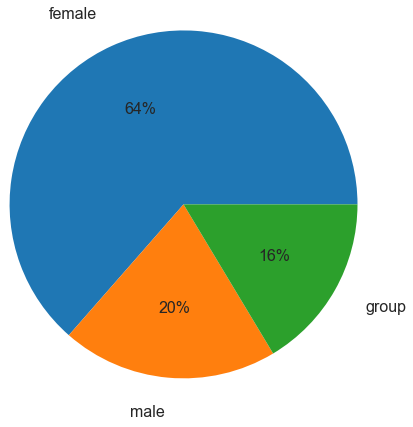

In [55]:
df_kiva_loans['borrower_genders'] = [elem if elem in ['female','male'] else 'group' 
                                     for elem in df_kiva_loans['borrower_genders'] ]

borrowers = df_kiva_loans['borrower_genders'].value_counts()

plot = borrowers.plot.pie(fontsize=16, autopct='%1.0f%%', labeldistance=1.2, radius=2)

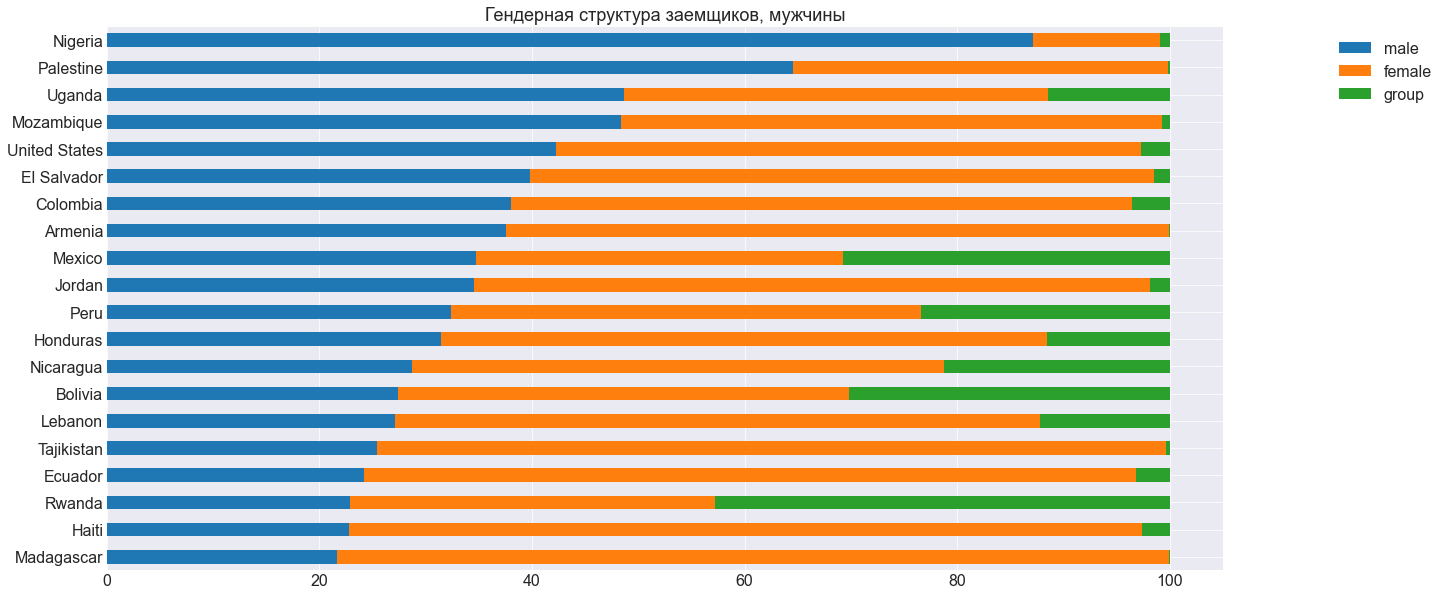

In [219]:
df_gender_by_country_m = \
    df_kiva_loans[df_kiva_loans['country'].isin(countries.index.values)]\
    .groupby(['country', 'borrower_genders'])['borrower_genders']\
    .count()\
    .groupby(level=0).apply(lambda x: 100 * x / x.sum())\
    .unstack('borrower_genders')\
    .fillna(0)\
    .sort_values(by=['male', 'female'])[-20:]

df_gender_by_country_m = df_gender_by_country_m[['male', 'female', 'group']]

plot = df_gender_by_country_m.plot.barh(
        figsize=(20,10)
        , fontsize=16
        , stacked=True
        , title='Гендерная структура заемщиков, мужчины')
plot.title.set_size(18)
plot.legend(loc=1, bbox_to_anchor=(1.2, 1), fontsize=16)
plot.set(ylabel=None, xlabel=None)
plt.show()

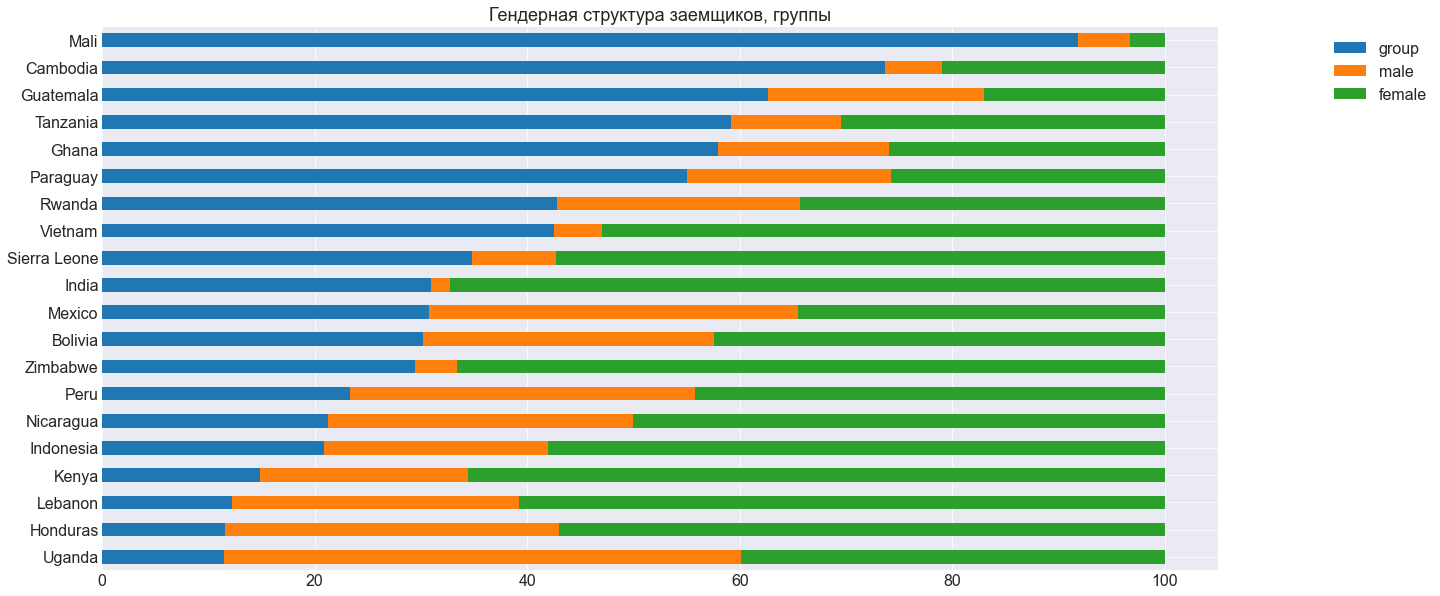

In [24]:
df_gender_by_country_g = \
    df_kiva_loans[df_kiva_loans['country'].isin(countries.index.values)]\
    .groupby(['country', 'borrower_genders'])['borrower_genders']\
    .count()\
    .groupby(level=0).apply(lambda x: 100 * x / x.sum())\
    .unstack('borrower_genders')\
    .fillna(0)\
    .sort_values(by=['group', 'male', 'female'])[-20:]
df_gender_by_country_g = df_gender_by_country_g[['group', 'male', 'female']]

plot = df_gender_by_country_g.plot.barh(
        figsize=(20,10)
        , fontsize=16
        , stacked=True
        , title='Гендерная структура заемщиков, группы')
plot.title.set_size(18)
plot.legend(loc=1, bbox_to_anchor=(1.2, 1), fontsize=16)
plot.set(ylabel=None, xlabel=None)
plt.show()

***

Как видно из графиков выше, в **Нигерии** и **Палестине** подавляющее большинство заёмщиков — мужчины,
а в **Мали** и **Камбодже** большинство - группа людей.

Также можно обратить внимание, что в общем преобладание женщин среди заемщиков намного выше, чем преобладание мужчин и групп людей (женщины доминируют в б**о**льшем количестве стран и с б**о**льшим процентным соотношением).

***

In [25]:
sectors = df_kiva_loans['sector'].value_counts()
loans_by_activity_sector = \
    df_kiva_loans[df_kiva_loans['sector'].isin(sectors[:9].index.values)]\
    .groupby(['sector', 'activity'])['loan_amount']\
    .count()\
    .reset_index()

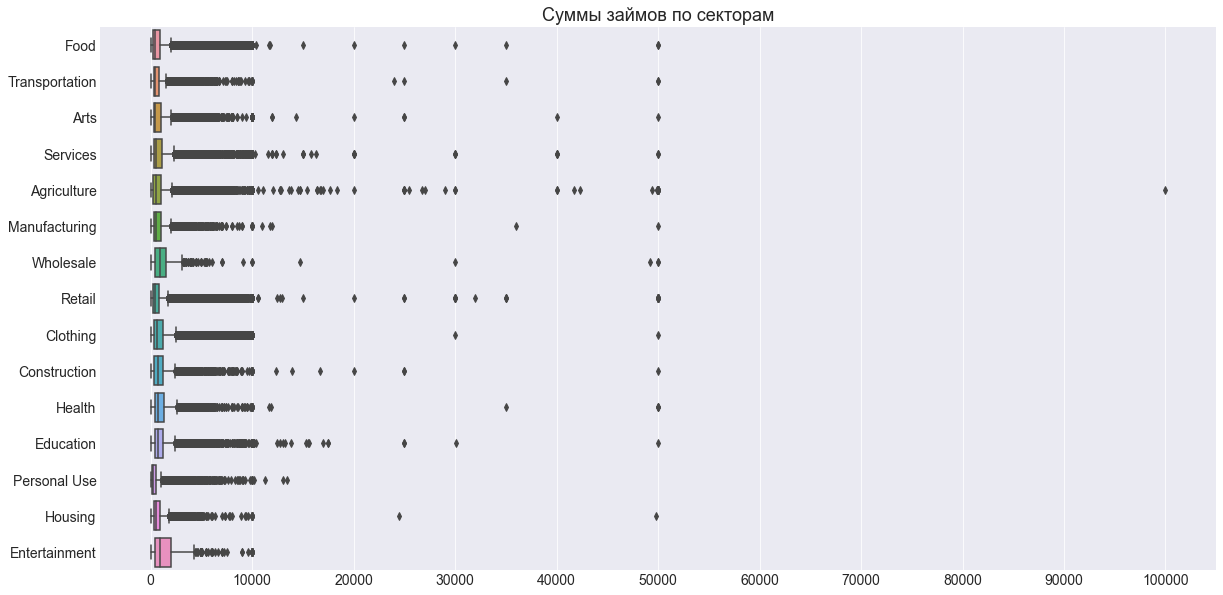

In [220]:
plt.figure(figsize=(20,10))
plt.title('Суммы займов по секторам', fontsize=18)
plt.xticks(np.arange(0, max(df_kiva_loans['loan_amount']+1), 10000))
plt.tick_params(labelsize=14)

sns.boxplot(x='loan_amount', y="sector", data=df_kiva_loans).set(ylabel=None, xlabel=None)
plt.show()

In [59]:
df_kiva_loans[df_kiva_loans['loan_amount'] >= 20000]

,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,...,date,ISO_x,world_region_x,MPI_x,ISO_y,world_region_y,MPI_y,ISO,world_region,MPI
34196,687045,50000.0,50000.0,Renewable Energy Products,Retail,to buy and sell Barefoot Power's Solar Lightin...,PE,Peru,Arequipa,USD,...,2014-03-21,PER,Latin America and Caribbean,0.053080,PER,Latin America and Caribbean,0.053080,PER,Latin America and Caribbean,0.053080
36570,689415,20000.0,20000.0,Bakery,Food,to purchase a vehicle to distribute her local ...,IQ,Iraq,NaN,USD,...,2014-03-26,IRQ,Arab States,0.050222,IRQ,Arab States,0.050222,IRQ,Arab States,0.050222
38725,691328,25000.0,25000.0,Construction Supplies,Construction,To supply construction materials for a vocatio...,RW,Rwanda,Kigali,USD,...,2014-03-31,RWA,Sub-Saharan Africa,0.242800,RWA,Sub-Saharan Africa,0.242800,RWA,Sub-Saharan Africa,0.242800
42697,695319,20000.0,20000.0,Beauty Salon,Services,to expand her salon’s space and services to in...,IQ,Iraq,NaN,USD,...,2014-04-08,IRQ,Arab States,0.050222,IRQ,Arab States,0.050222,IRQ,Arab States,0.050222
43182,695450,50000.0,50000.0,Renewable Energy Products,Retail,To buy and sell Barefoot Power's solar lightin...,KE,Kenya,Nairobi,USD,...,2014-04-09,KEN,Sub-Saharan Africa,0.209375,KEN,Sub-Saharan Africa,0.209375,KEN,Sub-Saharan Africa,0.209375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
659727,1323015,13225.0,50000.0,Arts,Arts,expand their retail sales channels and create ...,UG,Uganda,Kampala,USD,...,2017-06-19,UGA,Sub-Saharan Africa,0.375300,UGA,Sub-Saharan Africa,0.375300,UGA,Sub-Saharan Africa,0.375300
660211,1322535,25000.0,25000.0,Food,Food,to increase the company's production capacity ...,GH,Ghana,Accra,USD,...,2017-06-19,GHA,Sub-Saharan Africa,0.183500,GHA,Sub-Saharan Africa,0.183500,GHA,Sub-Saharan Africa,0.183500
660807,1323028,46125.0,50000.0,Renewable Energy Products,Retail,to distribute 400 pay-as-you-go solar systems ...,PK,Pakistan,Karachi,USD,...,2017-06-20,PAK,South Asia,0.233167,PAK,South Asia,0.233167,PAK,South Asia,0.233167
662660,1325702,30000.0,30000.0,Renewable Energy Products,Retail,to import and stock clean energy products such...,HT,Haiti,Port-au-Prince,USD,...,2017-06-22,HTI,Latin America and Caribbean,0.293800,HTI,Latin America and Caribbean,0.293800,HTI,Latin America and Caribbean,0.293800


In [319]:
max_loan_amount_bycountry = df_kiva_loans[df_kiva_loans['loan_amount'] >= 20000]['country'].value_counts()
max_loan_amount_bysector = df_kiva_loans[df_kiva_loans['loan_amount'] >= 20000]['sector'].value_counts()
max_loan_amount_bygender = df_kiva_loans[df_kiva_loans['loan_amount'] >= 20000]['borrower_genders'].value_counts()

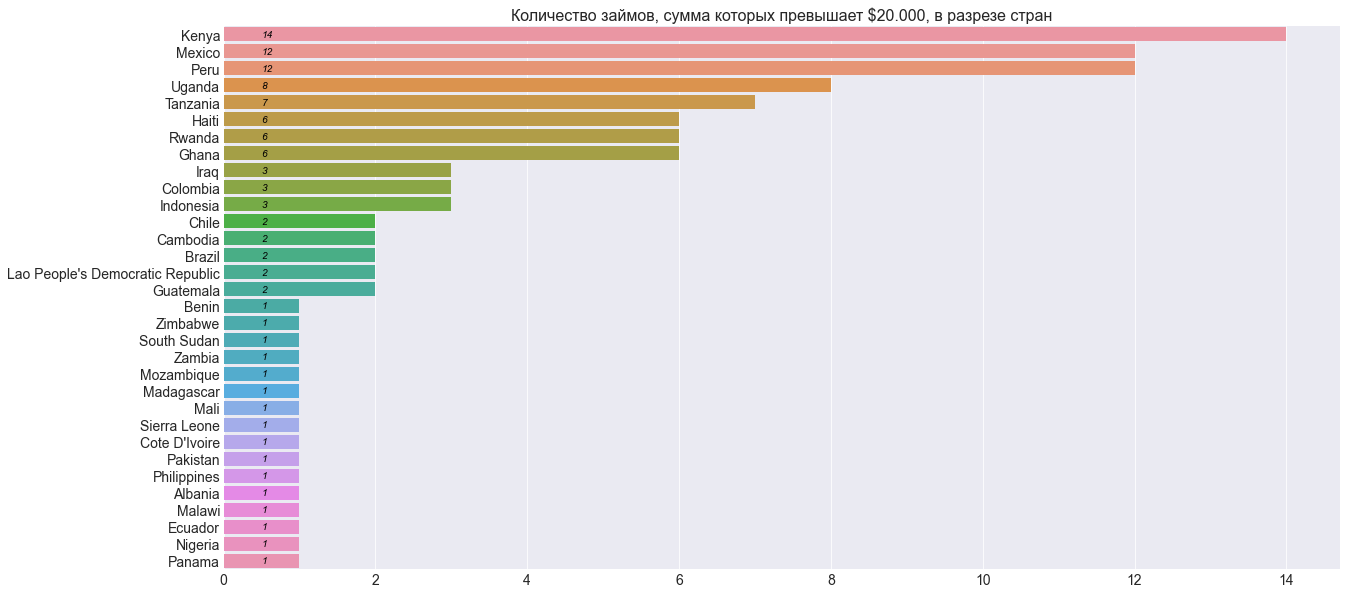

In [302]:
plt.figure(figsize=(20,10))
plt.title('Количество займов, сумма которых превышает $20.000, в разрезе стран', fontsize=16)
plt.tick_params(labelsize=14)
sns.barplot(y=max_loan_amount_bycountry.index, x=max_loan_amount_bycountry.values)
for index, value in enumerate(max_loan_amount_bycountry.values):
    plt.text(0.5, index, value, 
             fontsize=10, fontweight=500, color='black', style = 'italic', ha='left', va='center')
plt.show()

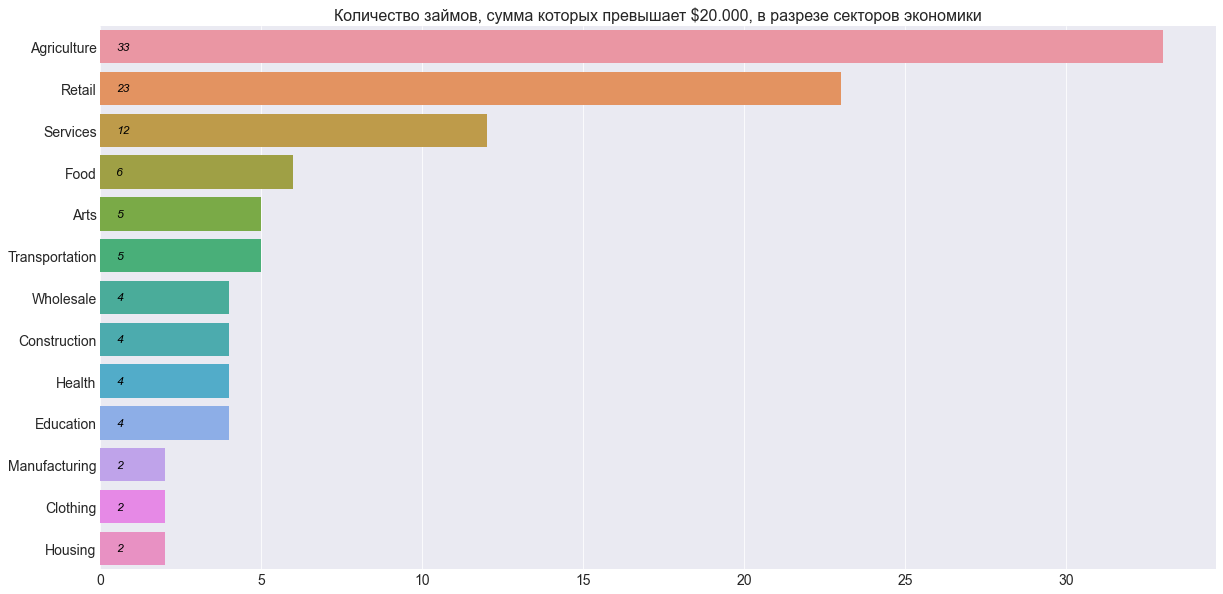

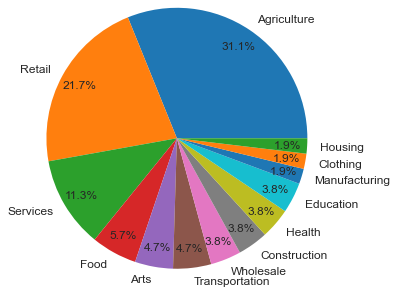

In [301]:
plt.figure(figsize=(20,10))
plt.title('Количество займов, сумма которых превышает $20.000, в разрезе секторов экономики', fontsize=16)
plt.tick_params(labelsize=14)
sns.barplot(y=max_loan_amount_bysector.index, x=max_loan_amount_bysector.values)
for index, value in enumerate(max_loan_amount_bysector.values):
    plt.text(0.5, index, value, 
             fontsize=12, fontweight=500, color='black', style = 'italic', ha='left', va='center')
plt.show()

plt.pie(max_loan_amount_bysector.values, autopct='%1.1f%%', pctdistance=0.85, 
        radius=1.5, textprops={'fontsize': 12},
        labels=max_loan_amount_bysector.index, labeldistance=1.1)
plt.show()

In [190]:
max_loan_amount_activities = df_kiva_loans[df_kiva_loans['loan_amount'] >= 50000]['use'].value_counts()
max_loan_amount_activities

create jobs through environmentally-friendly microentrepreneurship                                                                                                                                                                1
to enable 5,000 additional small-holder farmers across rural Kenya to sustainably harvest croton nuts—an abundant and indigenous crop with no previous commercial use                                                             1
to provide community trauma services in South Sudan.                                                                                                                                                                              1
to expand weather, farming information and financing for 500 cocoa farmers through mobile services in Ghana.                                                                                                                      1
To purchase raw materials in order to produce and distribute more life-changing clean co

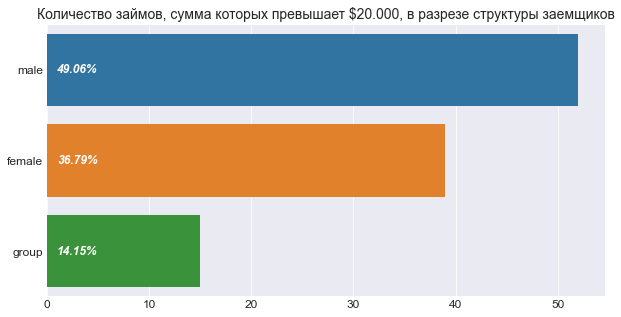

In [340]:
plt.figure(figsize=(10,5))
plt.title('Количество займов, сумма которых превышает $20.000, в разрезе структуры заемщиков', fontsize=14)
plt.tick_params(labelsize=12)
sns.barplot(y=max_loan_amount_bygender.index, x=max_loan_amount_bygender.values)
for index, value in enumerate((max_loan_amount_bygender.values / max_loan_amount_bygender.sum())*100):
    plt.text(1, index, "%.2f%%" % (value), 
             fontsize=12, fontweight=1000, color='w', style = 'italic', ha='left', va='center')
plt.show()

# plt.pie(max_loan_amount_bygender.values, autopct='%1.1f%%', radius=1.1, textprops={'fontsize': 14, 'color':'w'},
#        labels=max_loan_amount_bygender.index, labeldistance=1.1)
# plt.show()

***
Изучив наиболее крупные займы (сумма которых превышает $20.000) можно сделать следующие выводы:

1. Наибольшее количество таких займов выдано в **Кении**, **Мексике** и **Перу**.
2. Преобладающая отрасль экономики: **сельское хозяйство**, **розничная торговля**, **сфера услуг**
3. Половина таких займов (49%) получена мужчинами
***

In [996]:
# Наблюдаемое отклонение от среднего
dev = (df_kiva_loans['loan_amount']-df_kiva_loans['loan_amount'].mean()).abs()
# Стандартное отклонение
std = df_kiva_loans['loan_amount'].std()
# Фильтруем исходный набор данных
df_kiva_loans_trimmed = df_kiva_loans[~(dev>3*std)]

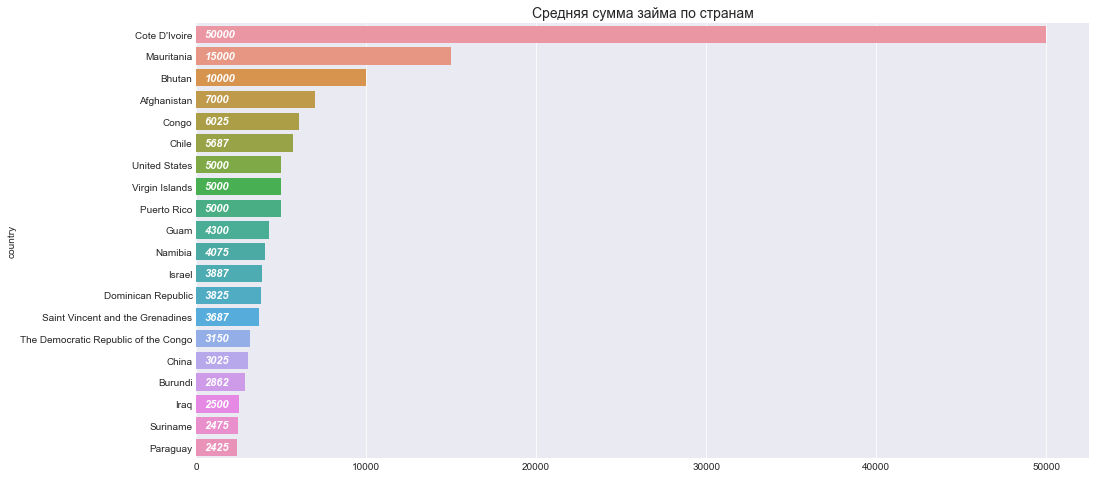

In [427]:
top_country_median = df_kiva_loans\
    .groupby(['country'])['loan_amount']\
    .median()\
    .sort_values(ascending=False)\
    .head(20)

plt.figure(figsize=(16,8))
plt.title('Средняя сумма займа по странам', fontsize=14)
sns.barplot(x=top_country_median.values, y=top_country_median.index)
for index, value in enumerate(top_country_median):
    plt.text(500, index, "%d" % (value), 
             fontsize=11, fontweight=1000, color='w', style = 'italic', ha='left', va='center')
plt.show()

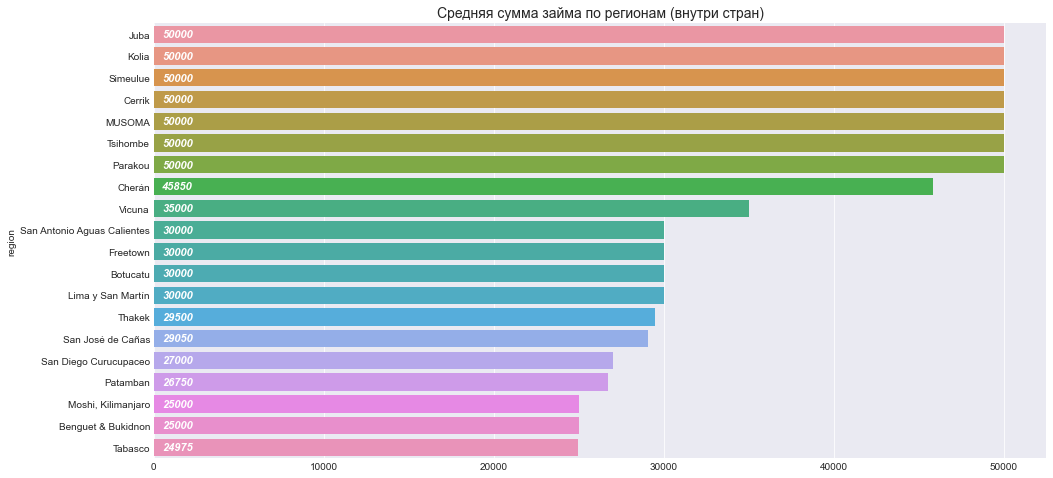

In [430]:
top_region_median = df_kiva_loans\
    .groupby(['region'])['loan_amount']\
    .median()\
    .sort_values(ascending=False)\
    .head(20)

plt.figure(figsize=(16,8))
plt.title('Средняя сумма займа по регионам (внутри стран)', fontsize=14)
sns.barplot(x=top_region_median.values, y=top_region_median.index)
for index, value in enumerate(top_region_median):
    plt.text(500, index, "%d" % (value), 
             fontsize=11, fontweight=1000, color='w', style = 'italic', ha='left', va='center')
plt.show()

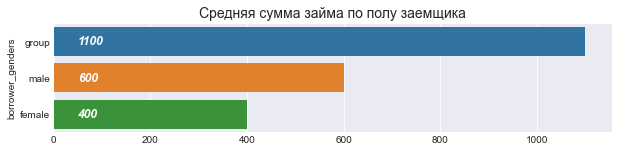

In [440]:
gender_median = df_kiva_loans\
    .groupby(['borrower_genders'])['loan_amount']\
    .median()\
    .sort_values(ascending=False)

plt.figure(figsize=(10,2))
plt.title('Средняя сумма займа по полу заемщика', fontsize=14)
sns.barplot(x=gender_median.values, y=gender_median.index)
for index, value in enumerate(gender_median):
    plt.text(50, index, "%d" % (value), 
             fontsize=12, fontweight=1000, color='w', style = 'italic', ha='left', va='center')
plt.show()

***
Наибольшая средняя сумма займа наблюдается в странах **Кот-д’Ивуар**, **Мавритания**, **Бутан**.

Наибольшая средняя сумма займа в разрезе пола заемщика наблюдается среди группы людей, среди женщин наименьшая средняя сумма займа.
***

***
***
***

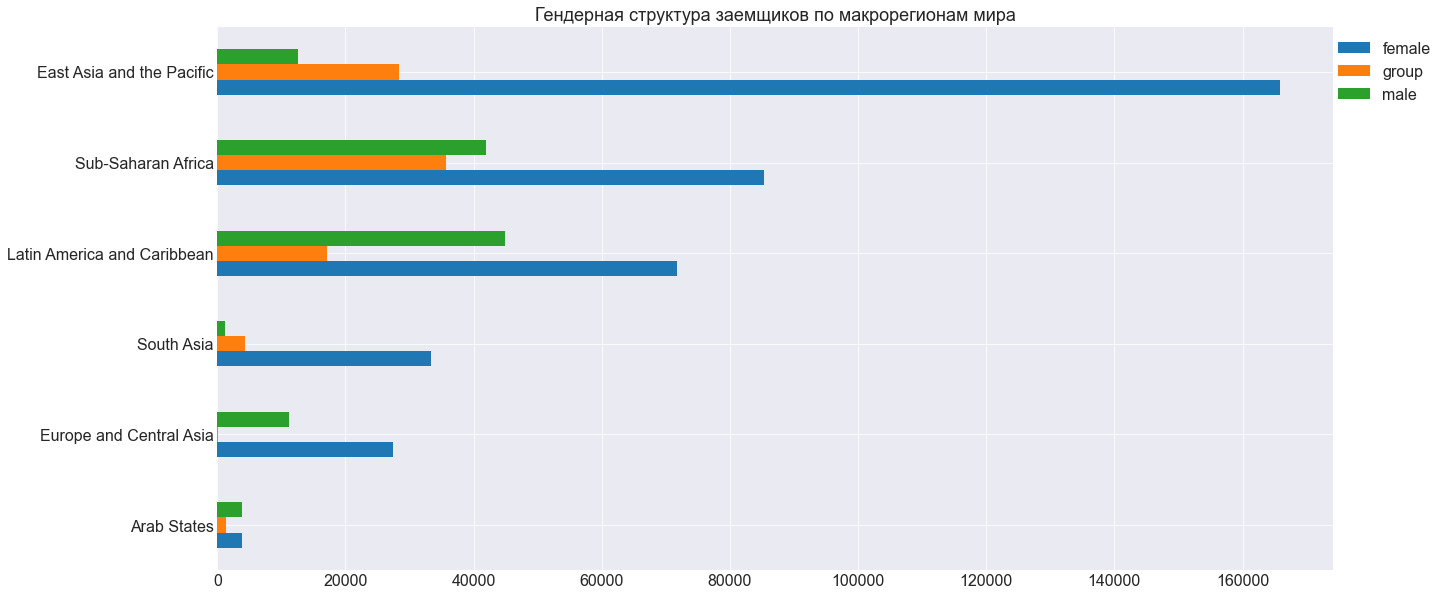

In [749]:
borrower_genders_by_world_region = df_kiva_loans\
    .groupby(['world_region', 'borrower_genders'])['borrower_genders']\
    .count()\
    .unstack('borrower_genders')\
    .sort_values(by=['female', 'male', 'group'])

# не смог разобраться, как построить шесть отдельных графиков для каждого региона 
# (регион - название графика, по осям - пол и количество)
# поэтому предлагаю вариант на одном графике

plot = borrower_genders_by_world_region.plot.barh(
        figsize=(20,10), 
        fontsize=16, 
        title='Гендерная структура заемщиков по макрорегионам мира')
plot.title.set_size(18)
plot.legend(loc=1, bbox_to_anchor=(1.1, 1), fontsize=16)
plot.set(ylabel=None, xlabel=None)
plt.show()

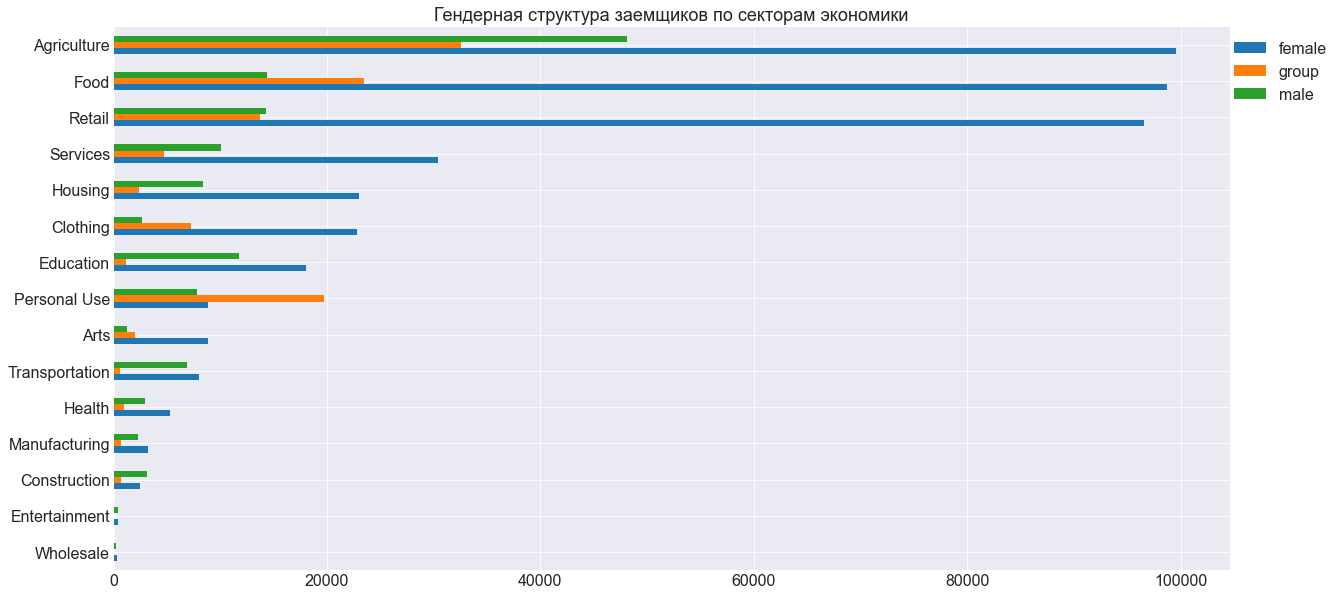

In [801]:
borrower_genders_by_sector = df_kiva_loans\
    .groupby(['sector', 'borrower_genders'])['borrower_genders']\
    .count()\
    .unstack('borrower_genders')\
    .sort_values(by=['female', 'male', 'group'])

# общий график по всем секторам

plot = borrower_genders_by_sector.plot.barh(
        figsize=(20,10), 
        fontsize=16, 
        title='Гендерная структура заемщиков по всем секторам экономики')
plot.title.set_size(18)
plot.legend(loc=1, bbox_to_anchor=(1.1, 1), fontsize=16)
plot.set(ylabel=None, xlabel=None)

plt.show()

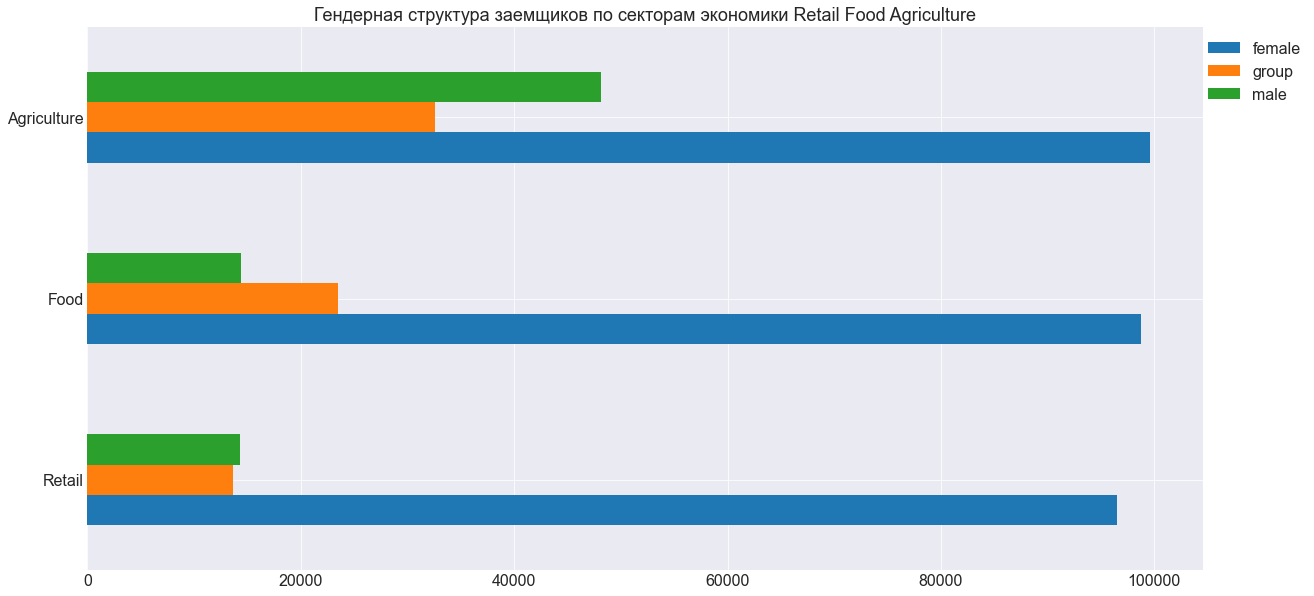

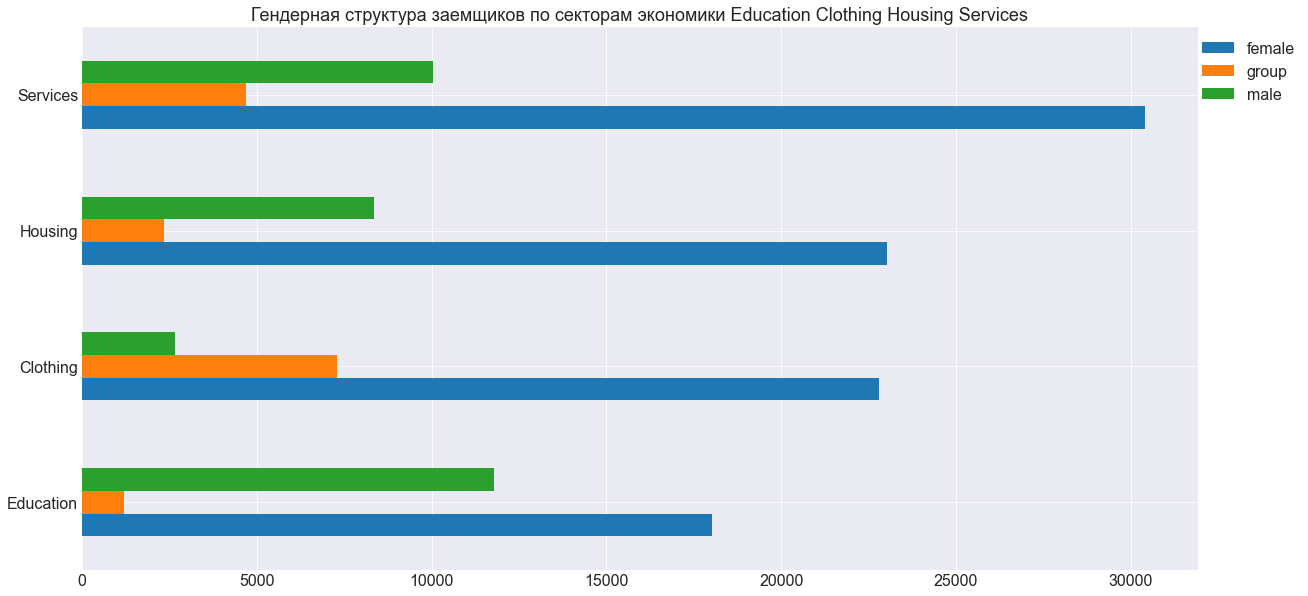

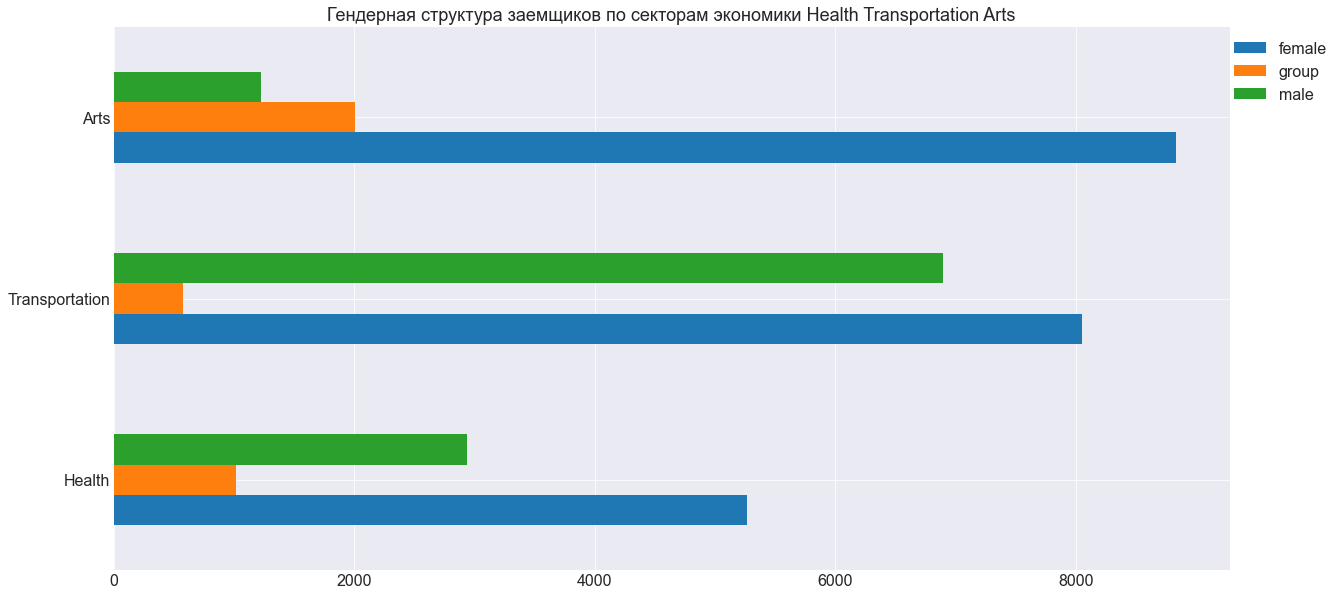

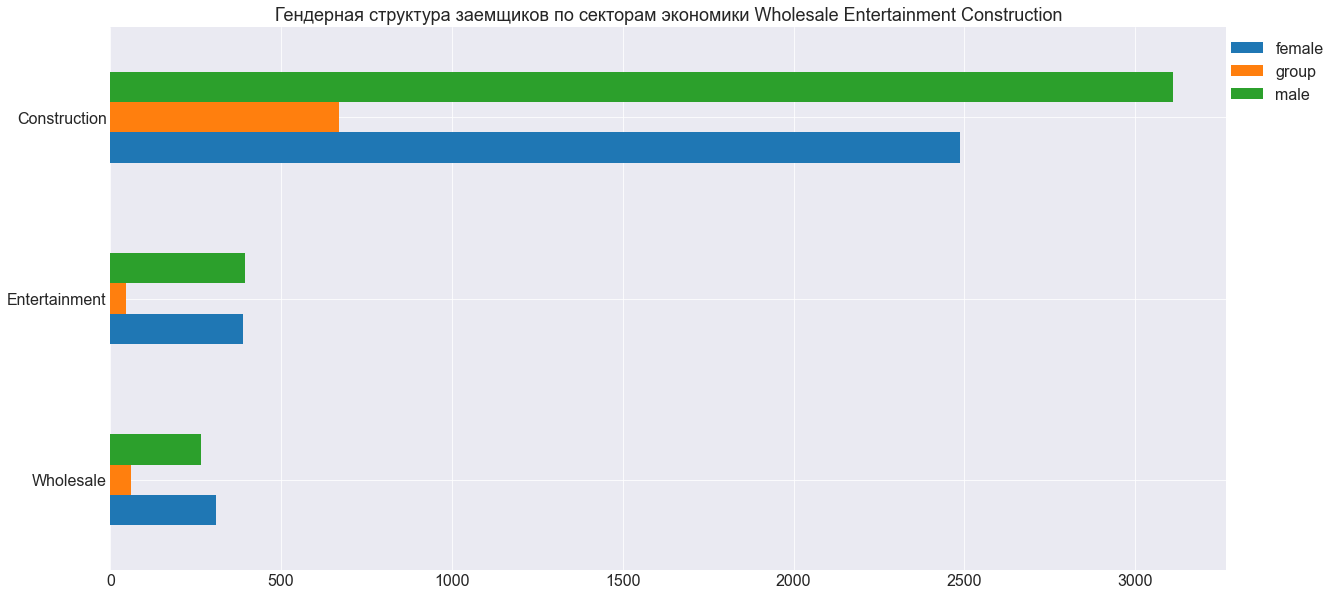

In [802]:
# из-за большого разброса значений, график можно разбить на несколько, для удобства

plot = borrower_genders_by_sector[-3:].plot.barh(
        figsize=(20,10), 
        fontsize=16, 
        title=('Гендерная структура заемщиков по секторам экономики ' + 
        ' '.join(borrower_genders_by_sector[-3:].index.to_list())))
plot.title.set_size(18)
plot.legend(loc=1, bbox_to_anchor=(1.1, 1), fontsize=16)
plot.set(ylabel=None, xlabel=None)

plot = borrower_genders_by_sector[8:12].plot.barh(
        figsize=(20,10), 
        fontsize=16, 
        title=('Гендерная структура заемщиков по секторам экономики ' + 
        ' '.join(borrower_genders_by_sector[8:12].index.to_list())))
plot.title.set_size(18)
plot.legend(loc=1, bbox_to_anchor=(1.1, 1), fontsize=16)
plot.set(ylabel=None, xlabel=None)

plot = borrower_genders_by_sector[4:7].plot.barh(
        figsize=(20,10), 
        fontsize=16, 
        title=('Гендерная структура заемщиков по секторам экономики ' + 
        ' '.join(borrower_genders_by_sector[4:7].index.to_list())))
plot.title.set_size(18)
plot.legend(loc=1, bbox_to_anchor=(1.1, 1), fontsize=16)
plot.set(ylabel=None, xlabel=None)

plot = borrower_genders_by_sector[:3].plot.barh(
        figsize=(20,10), 
        fontsize=16, 
        title=('Гендерная структура заемщиков по секторам экономики ' + 
        ' '.join(borrower_genders_by_sector[:3].index.to_list())))
plot.title.set_size(18)
plot.legend(loc=1, bbox_to_anchor=(1.1, 1), fontsize=16)
plot.set(ylabel=None, xlabel=None)

plt.show()

***
Как видно из графиков, во всех регионах мира лидируют заемщики - женщины.

Также женщины лидируют в большинстве секторов экономики (кроме сферы строительства и развлечений).

Данные наблюдения коррелируются с тем фактом, что женщины в целом преобладают в числе заемщиков Kiva.

***

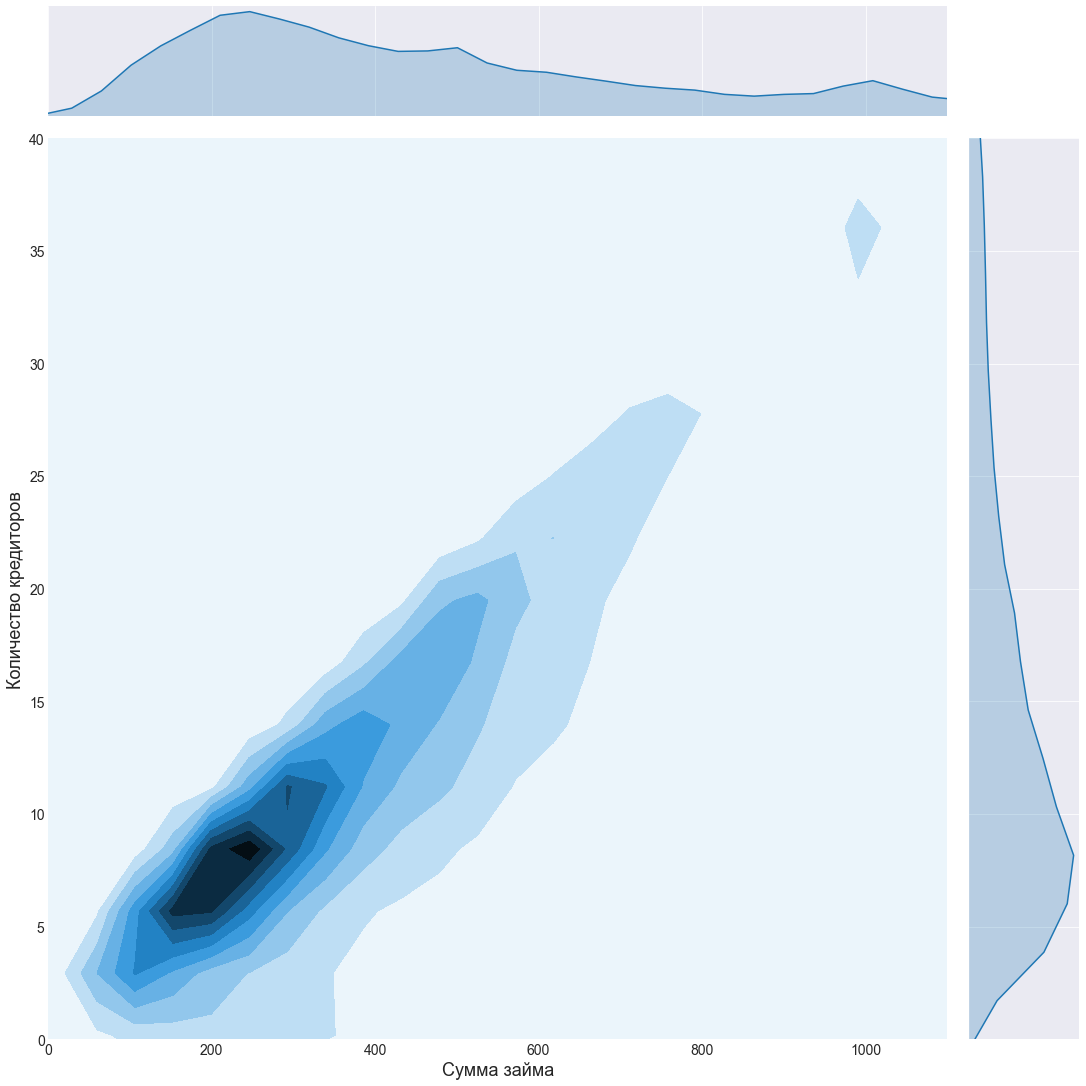

In [870]:
p = sns.jointplot(x="loan_amount", y="lender_count", data=df_kiva_loans_trimmed, 
                  kind='kde', height=15, ratio=7, xlim=[0,1100] , ylim=[0,40])\
        .set_axis_labels("Сумма займа", "Количество кредиторов", size=18)

p.ax_joint.tick_params(labelsize=14)

plt.show()

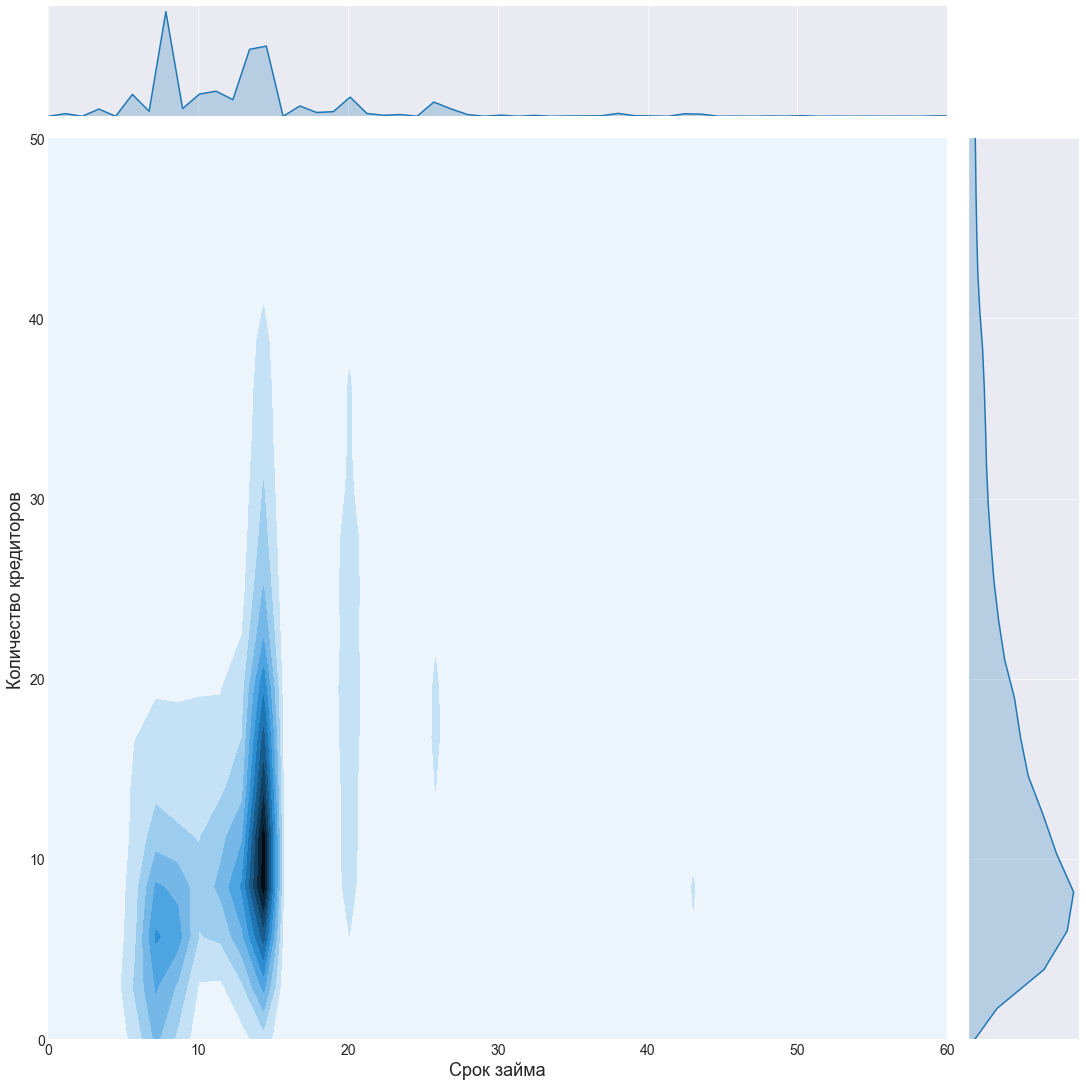

In [869]:
t = sns.jointplot(x="term_in_months", y="lender_count", data=df_kiva_loans_trimmed, 
                  kind='kde', height=15, ratio=7, xlim=[0,60] , ylim=[0,50])\
        .set_axis_labels("Срок займа", "Количество кредиторов", size=18)

t.ax_joint.tick_params(labelsize=14)

plt.show()

***
В общем, возрастающее количество кредиторов, требуемое для финансирования заявки, можно объяснить возрастающей суммой займа.

Также можно видеть наличие большого количества заявок на суммы от **150** до **350** долларов с количеством кредиторов **3–12**.

Большое количество кредиторов финансируют заявки на срок **12-15** месяцев
***

In [968]:
# выбираем из даннх строки, где заполнено значение в столбце MPI
mpi = df_kiva_loans_trimmed.dropna(subset=['MPI'])[df_kiva_loans_trimmed['MPI'] != 0]

# группируем данные по странам и индексу бедности, для каждой считаем мпедиану суммы займа и срока погашения
# сортируем по убыванию индекса бедности. Чем больше значение индекса - тем беднее население страны
mpi = mpi.groupby(['country', 'MPI'])\
    .agg({'loan_amount' : 'median', 'term_in_months' : 'median'})\
    .reset_index()\
    .sort_values(by=['MPI'], ascending=False)

<ipython-input-968-f4d425b040d1>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mpi = df_kiva_loans_trimmed.dropna(subset=['MPI'])[df_kiva_loans_trimmed['MPI'] != 0]


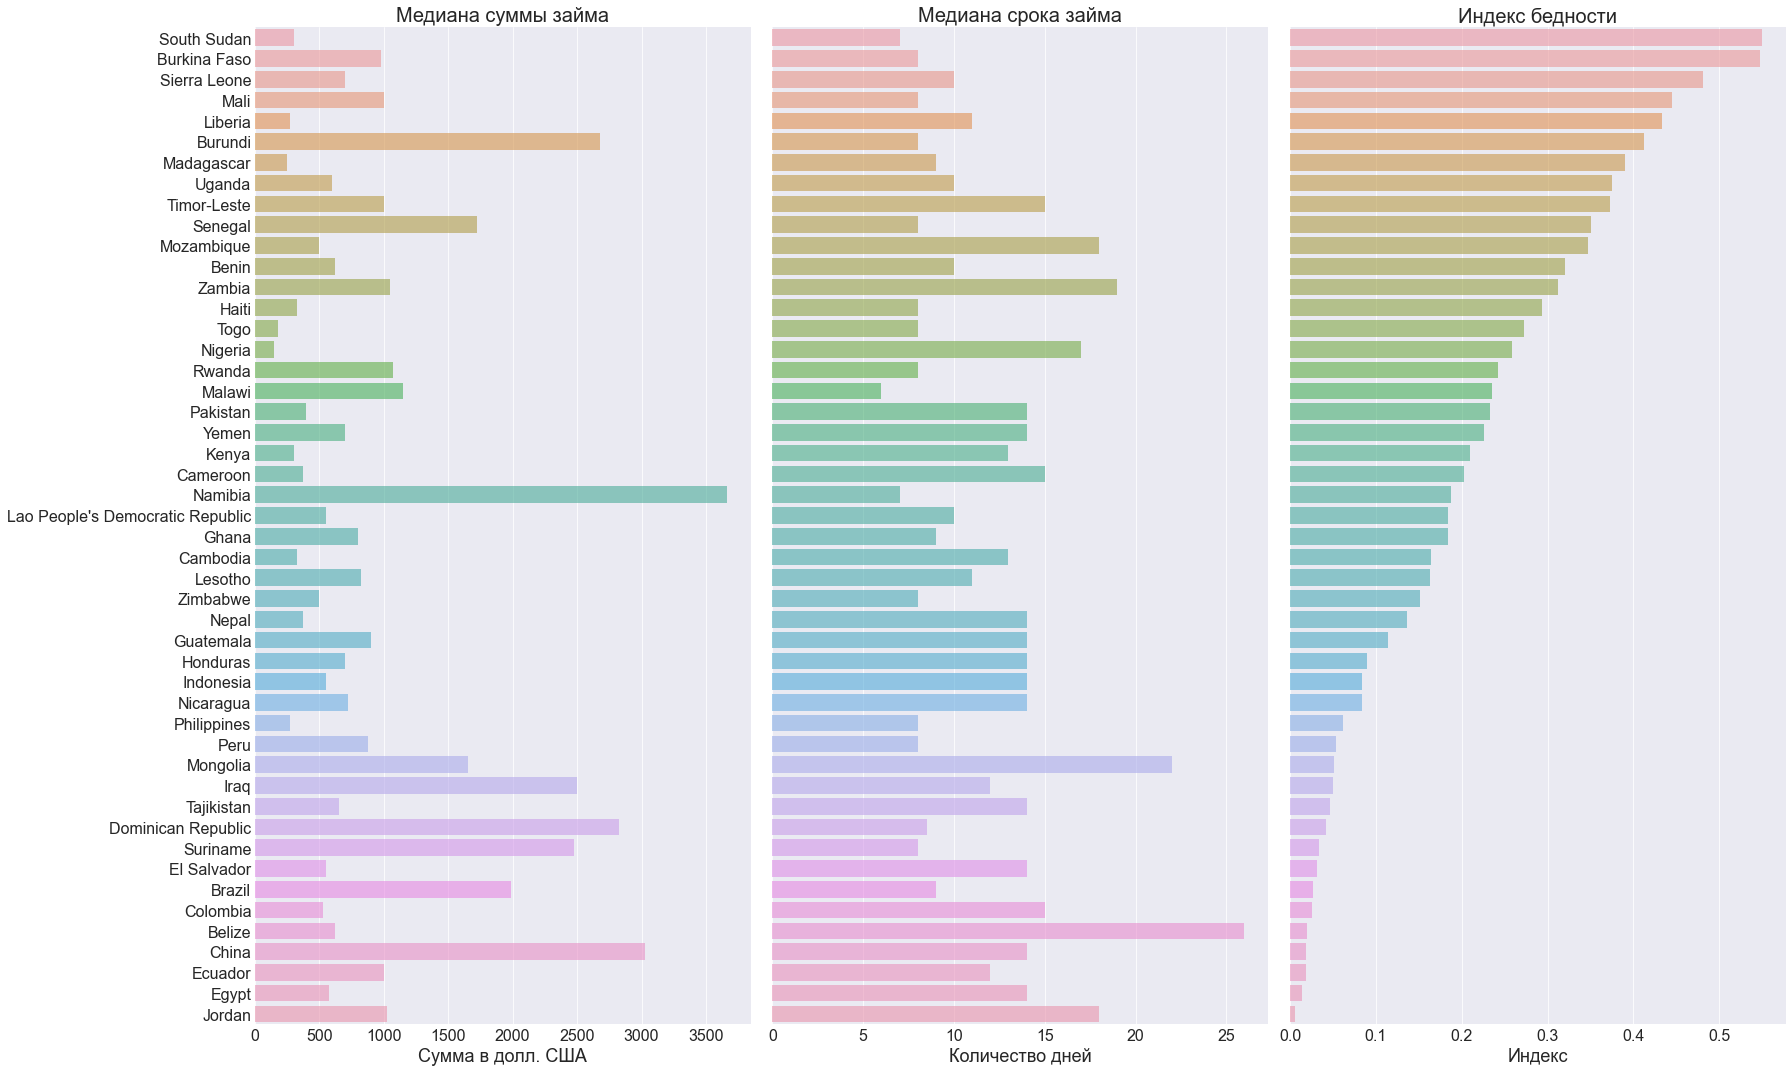

In [979]:
f,ax=plt.subplots(1, 3, sharey=True, figsize=(25,15))

sns.barplot(y='country', x='loan_amount', data=mpi, alpha=0.6, ax=ax[0])
ax[0].set_title("Медиана суммы займа", fontsize=20)
ax[0].set_xlabel('Сумма в долл. США', fontsize=18)
ax[0].set_ylabel(None)
ax[0].tick_params(labelsize=16)

sns.barplot(y='country', x='term_in_months', data=mpi, alpha=0.6, ax=ax[1])
ax[1].set_title("Медиана срока займа", fontsize=20)
ax[1].set_xlabel('Количество дней', fontsize=18)
ax[1].set_ylabel(None)
ax[1].tick_params(labelsize=16)

sns.barplot(y='country', x='MPI', data=mpi, alpha=0.6, ax=ax[2])
ax[2].set_title("Индекс бедности", fontsize=20)
ax[2].set_xlabel('Индекс', fontsize=18)
ax[2].set_ylabel(None)
ax[2].tick_params(labelsize=16)

plt.tight_layout()
plt.show()

***
Как видно на графиках выше, не прослеживается прямая связь между индексом бедности, средней суммой займа и средним сроком займа.

Средние суммы займа и сроки займа очень сильно варьируются от страны к стране. При этом на общем фоне сильно выделяются **Бурунди** и **Намибия**, где достаточно высокая средняя сумма займа, несмотря на достаточно высокий уровень бедности этих стран.

Также можно заметить незначительную тенденцию к снижению среднего срока займа в наиболее бедных странах.
***

In [1005]:
# drop na (missing) values
df_loans_dates = df_kiva_loans_trimmed.dropna(subset=['disbursed_time', 'funded_time'], how='any', inplace=False)

# dates columns:
dates = ['posted_time','disbursed_time']

# format dates:
df_loans_dates[dates] = df_loans_dates[dates].applymap(lambda x : x.split('+')[0])
df_loans_dates[dates] = df_loans_dates[dates].apply(pd.to_datetime)

# calculate time interval
df_loans_dates.loc[:, 'time_funding'] = df_loans_dates['disbursed_time']-df_loans_dates['posted_time']
df_loans_dates.loc[:, 'time_funding'] = df_loans_dates['time_funding'] / timedelta(days=1) 

# remove outliers +-3 sigma
dev = (df_loans_dates['time_funding']-df_loans_dates['time_funding'].mean()).abs()
std = df_loans_dates['time_funding'].std()
# Keep rows where time_funding interval > 0 only
df_loans_dates_trimmed = df_loans_dates[~(dev>3*std) & (df_loans_dates.loc[:, 'time_funding']>0)]

df_loans_dates_trimmed['monthly_repayment'] = (df_loans_dates_trimmed['loan_amount'] / 
                                               df_loans_dates_trimmed['term_in_months'])

<ipython-input-1005-03d0c788d7a0>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loans_dates_trimmed['monthly_repayment'] = (df_loans_dates_trimmed['loan_amount'] /


In [1006]:
# фильтруем данные от выбросов
dev_term = (df_kiva_loans_trimmed['term_in_months']-df_kiva_loans_trimmed['term_in_months'].mean()).abs()
std_term = df_kiva_loans_trimmed['term_in_months'].std()
df_kiva_loans_trimmed = df_kiva_loans_trimmed[~(dev_term>3*std_term)]

dev_repayment = (df_loans_dates_trimmed['monthly_repayment']-df_loans_dates_trimmed['monthly_repayment']\
                 .mean()).abs()
std_repayment = df_loans_dates_trimmed['monthly_repayment'].std()
df_loans_dates_trimmed = df_loans_dates_trimmed[~(dev_repayment>3*std_repayment)]

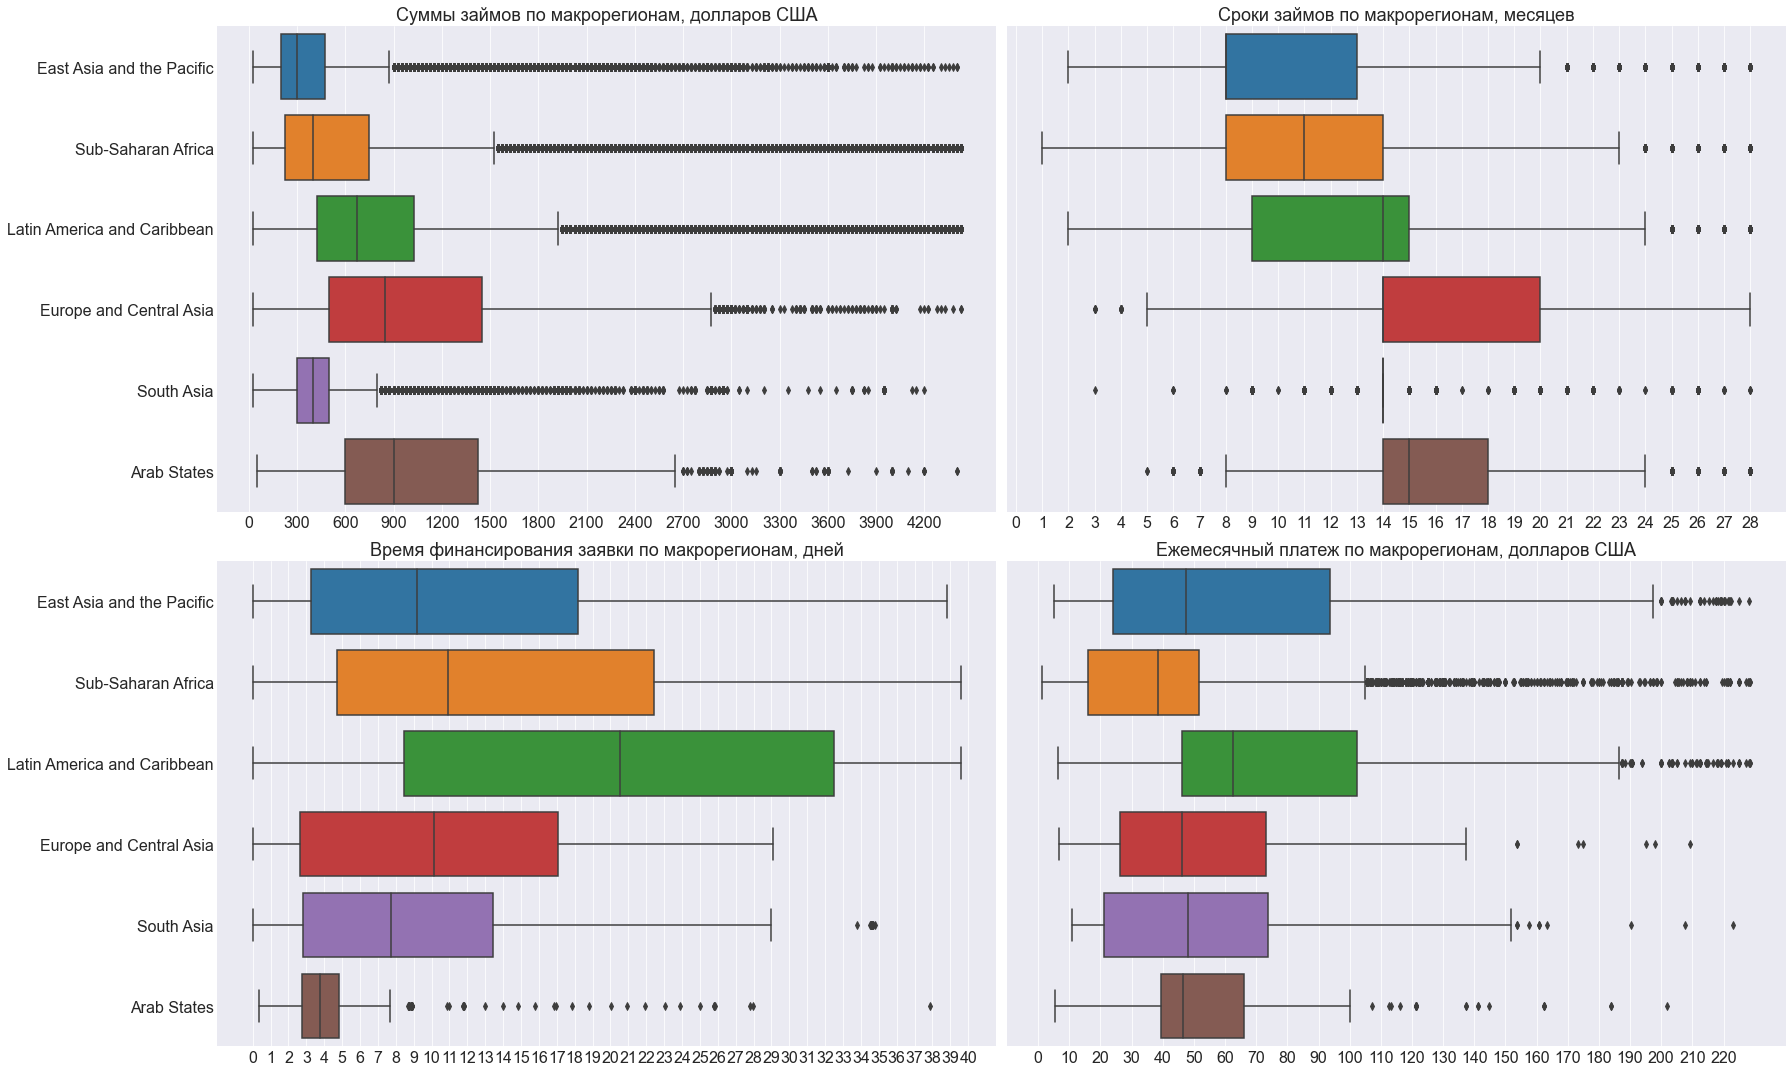

In [1017]:
f,ax=plt.subplots(2, 2, sharey=True, figsize=(25,15))

sns.boxplot(x='loan_amount', y="world_region", order=regions_list, data=df_kiva_loans_trimmed, ax=ax[0][0])
ax[0][0].set_title("Суммы займов по макрорегионам, долларов США", fontsize=18)
ax[0][0].set_xticks(np.arange(0, max(df_kiva_loans_trimmed['loan_amount']+1), 300))
ax[0][0].set_ylabel(None)
ax[0][0].set_xlabel(None)
ax[0][0].tick_params(labelsize=16)

sns.boxplot(x='term_in_months', y="world_region", order=regions_list, data=df_kiva_loans_trimmed, ax=ax[0][1])
ax[0][1].set_title("Сроки займов по макрорегионам, месяцев", fontsize=18)
ax[0][1].set_xticks(np.arange(0, max(df_kiva_loans_trimmed['term_in_months']+1)))
ax[0][1].set_ylabel(None)
ax[0][1].set_xlabel(None)
ax[0][1].tick_params(labelsize=16)

sns.boxplot(x='time_funding', y="world_region", order=regions_list, data=df_loans_dates_trimmed, ax=ax[1][0])
ax[1][0].set_title("Время финансирования заявки по макрорегионам, дней", fontsize=18)
ax[1][0].set_xticks(np.arange(0, max(df_loans_dates_trimmed['time_funding']+1)))
ax[1][0].set_ylabel(None)
ax[1][0].set_xlabel(None)
ax[1][0].tick_params(labelsize=16)

sns.boxplot(x='monthly_repayment', y="world_region", order=regions_list, data=df_loans_dates_trimmed, ax=ax[1][1])
ax[1][1].set_title("Ежемесячный платеж по макрорегионам, долларов США", fontsize=18)
ax[1][1].set_xticks(np.arange(0, max(df_loans_dates_trimmed['monthly_repayment']+1), 10))
ax[1][1].set_ylabel(None)
ax[1][1].set_xlabel(None)
ax[1][1].tick_params(labelsize=16)

plt.tight_layout()
plt.show()

***
Регионы на графиках расположены в порядке убывания количества займов.

На графиках видно, что более бедные страны регионов Восточная Азия и Южная Азия характеризуются меньшей суммой займа, но при этом бОльшим ежемесячным платежом.

Также хорошо видно, что заявки из Латинсокй Америки финансируются намного дольше остальных регионов, несмотря на не самые большие суммы займов.

Увеличенные сроки займов в европейском регионе можно объяснить более высоким уровнем жизни, в связи с чем пользователи могут позволить себе брать более долгие займы с меньшим риском невозврата.

***